__Problems:__   
RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward. 

The reason for the above problem is that I made consecutive calls to the same calculation graph. Let's analyze which step led to the above problems when I built a fully connected network.

In [15]:
import torch
# Randomly generate our training samples and train labels
num_samples = 4000
num_features = 2
num_hiddens = 2
# train samples
X = torch.randn((num_samples, num_features), dtype=torch.float32)
true_W = torch.randn((num_hiddens, 1), requires_grad=True, dtype=torch.float32)
true_b = torch.randn(1, requires_grad=True, dtype=torch.float32)
Y = torch.mm(X, true_W) + true_b

In [16]:
X[:5], Y[:5], true_W, true_b

(tensor([[-0.4156,  1.2422],
         [-0.5978, -1.2458],
         [-0.7696,  0.6027],
         [ 1.9984, -0.1588],
         [ 0.3542, -1.5830]]),
 tensor([[ 3.5848],
         [-2.6023],
         [ 1.7859],
         [ 1.8110],
         [-2.7770]], grad_fn=<SliceBackward0>),
 tensor([[0.6795],
         [2.4370]], requires_grad=True),
 tensor([0.8400], requires_grad=True))

In [17]:
from utils.Common import relu, sgd, loss, DataLoader

In [18]:
# fc
def fc(x, w, b):
    return relu(torch.mm(x, w) + b)

In [19]:
# Randomly generate W and b and attach gradients
W = torch.normal(0, 0.01, size=(num_hiddens, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [20]:
batch_size = 20
lr = 0.01
num_epochs = 20
dataloader = DataLoader(X, Y, batch_size, shuffle=True)

In [21]:
for epoch in range(num_epochs):
    for x, y in dataloader:
        l = loss(fc(x, W, b), y)  
        l.backward()
        sgd([W, b], lr, batch_size)  
    if (epoch+1) % 5 == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, l))


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Where does the problem occur?

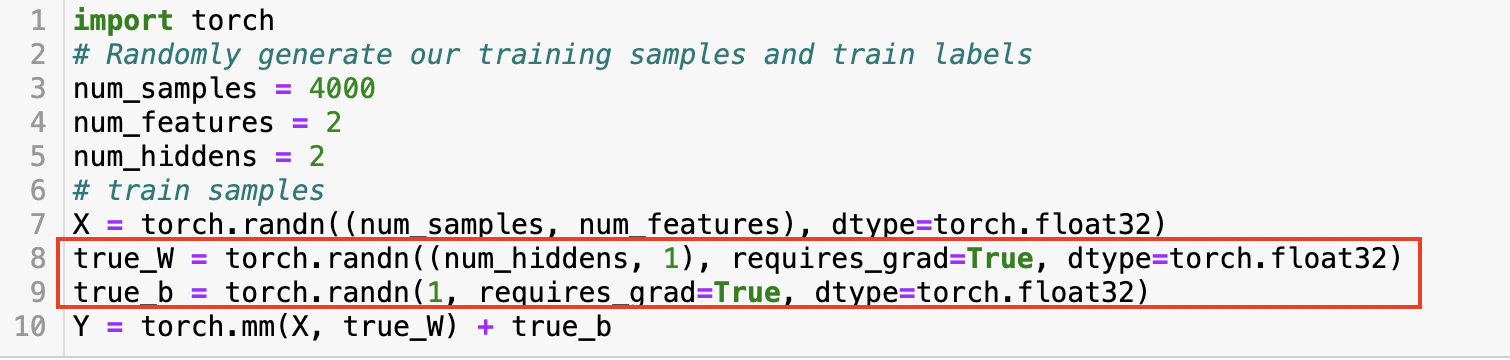   
The problem occurs in the red box in this picture. We can see that when I used W and b to create real labels, I attached gradients to W and b, causing the subsequent Y to also have gradient information.  


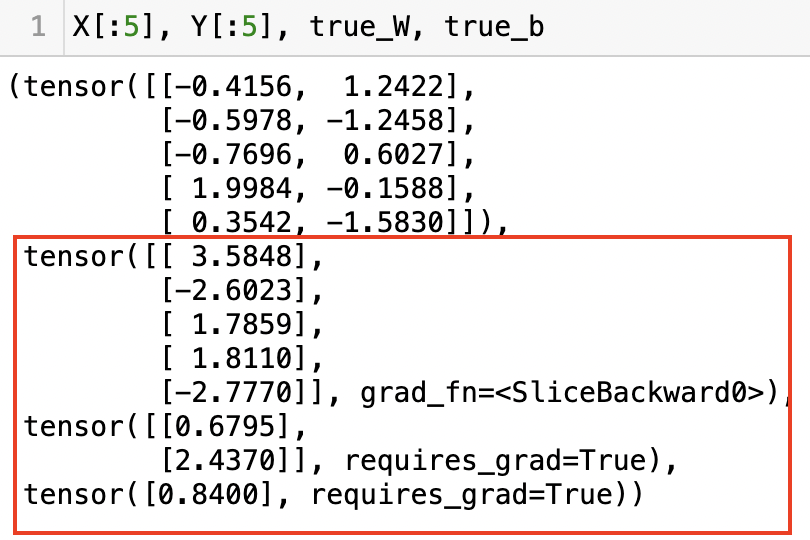

In PyTorch, we need to know that the most basic premise is: once a gradient is attached to a tensor, each subsequent operation using the tensor will generate a calculation graph.

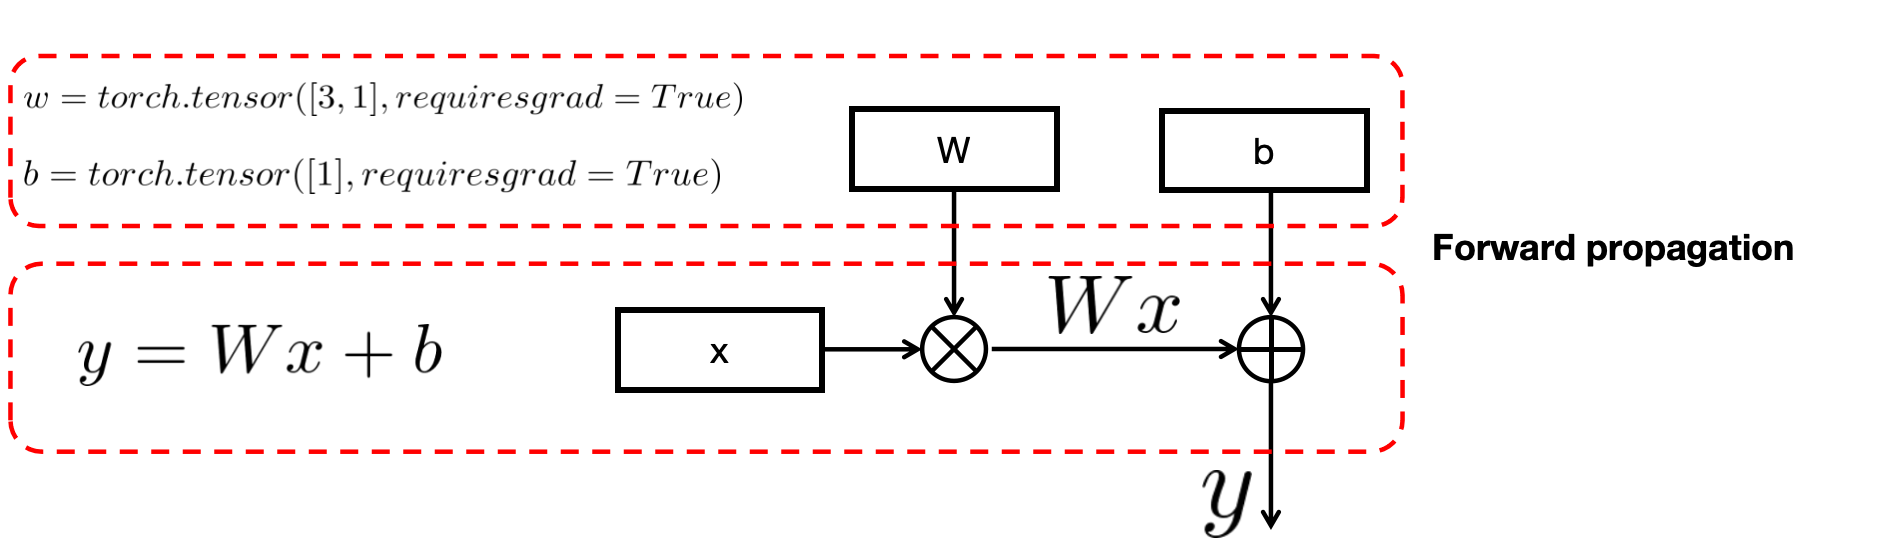

When performing backpropagation, in order to release memory, this calculation graph will be "consumed"   
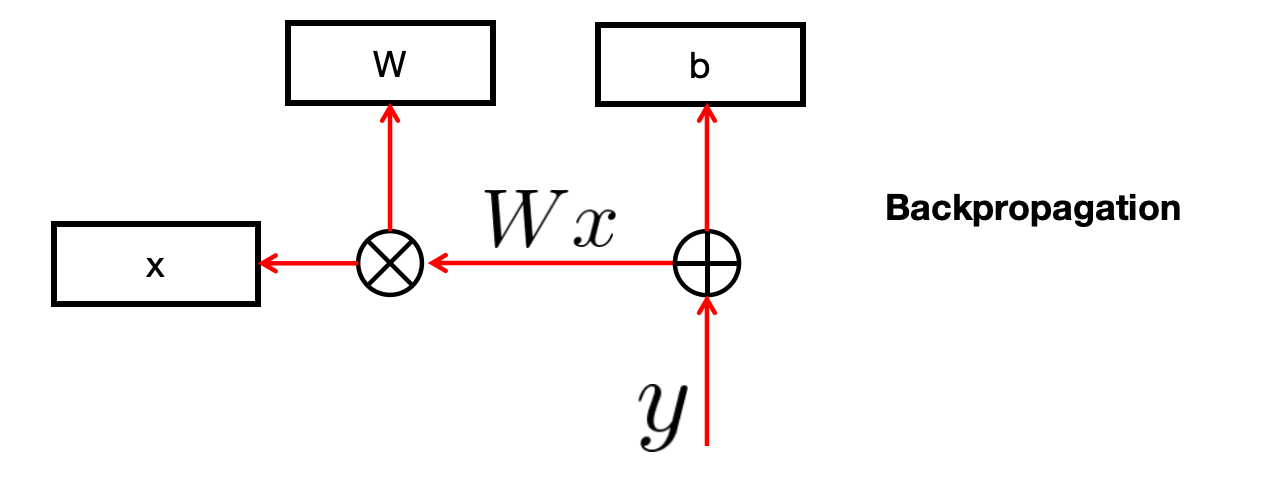

As mentioned before, since the previously created Y has been attached with a gradient, subsequent backpropagation is performed under the __same calculation graph__ (__the data Y loaded through the dataloader all have gradients__) , but the original calculation graph has been consumed, so the previous error occurred.